# GCP Model traning


This notebook is intended as a template for running models in GCP AI notebooks

* Set the model to the desired version model from the ./model/ConvLSTM-models
* set the parameteres
* Run it :)




**Imports**

In [46]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
import seaborn as sns
import os
from matplotlib.widgets import Slider
import glob
import h5py
from datahelpers import DemandGridDataset
from model.ConvLSTM import *
from model.ConvLSTM_models import VanillaConvLSTMFC, VanillaConvLSTM
from datetime import datetime
from datahelpers import standardize_grid
import json
from IPython.display import clear_output

def set_seed(seed: int):
    torch.manual_seed(seed)
    np.random.seed(seed)
set_seed(100)

**Dataloader**

In [47]:
SEGMENT_MIN=60
VERTICAL_LINES=4
HORIZONTAL_LINES=4
DATA_PATH="datasets/"
SUBSET = True
DATA_PREFIX="greenmobility_demand_prediction"
if SUBSET:
    DATA_PREFIX+='_CPH_SUB'
SEQ_LEN_SLICES=72
TEST=False
if TEST:
    DATA_PREFIX="test_"+DATA_PREFIX
    SEQ_LEN_SLICES=1

STANDARDIZE = False
RETURN_FEATURES = True


# For saving
MODEL_NAME="Linea_model"

In [48]:
# Params
batch_size = 1

# Load the dataset 
t1=datetime.now()
train_data = DemandGridDataset(DATA_PATH+DATA_PREFIX+"_train.csv", 
                         vertical_lines=VERTICAL_LINES, 
                         horizontal_lines=HORIZONTAL_LINES,
                         SEGMENT_MIN=SEGMENT_MIN,
                               SEQ_LEN_SLICES=SEQ_LEN_SLICES,
                              train=True,
                               return_features=RETURN_FEATURES,
                              standardize=STANDARDIZE)
print("Traning loaded in: ",(datetime.now()-t1).seconds)

# Pass filters to validation and test
if STANDARDIZE:
    STANDARDIZE = (train_data.mean_grid, train_data.std_grid)

t2=datetime.now()
test_data = DemandGridDataset(DATA_PATH+DATA_PREFIX+"_test.csv", 
                         vertical_lines=VERTICAL_LINES, 
                         horizontal_lines=HORIZONTAL_LINES,
                         SEGMENT_MIN=SEGMENT_MIN,
                              SEQ_LEN_SLICES=SEQ_LEN_SLICES,
                              train=False,
                              return_features=RETURN_FEATURES, 
                              standardize=STANDARDIZE)
print("Test loaded in: ",(datetime.now()-t2).seconds)
t2=datetime.now()
validation_data = DemandGridDataset(DATA_PATH+DATA_PREFIX+"_validation.csv", 
                         vertical_lines=VERTICAL_LINES, 
                         horizontal_lines=HORIZONTAL_LINES,
                         SEGMENT_MIN=SEGMENT_MIN,
                                    SEQ_LEN_SLICES=SEQ_LEN_SLICES,
                              train=False,
                                    return_features=RETURN_FEATURES, 
                                    standardize=STANDARDIZE)
print("Validation loaded in: ",(datetime.now()-t2).seconds)
print("Initializing loaders")
train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                          batch_size=batch_size, 
                                          shuffle=False)

validation_loader = torch.utils.data.DataLoader(dataset=validation_data, 
                                          batch_size=batch_size, 
                                          shuffle=False)
print("Total time:",(datetime.now()-t1).seconds)

Traning loaded in:  35
Test loaded in:  5
Validation loaded in:  1
Initializing loaders
Total time: 43


In [49]:
print(len(train_loader))
print(len(test_loader))
print(len(validation_loader))

6418
922
268


## Model selections 

We will start off with creating a simple linear model of the features - time of day, day of week and cars in avalible last 12 slices

There is one model for each gridcell location

In [ ]:
import itertools

In [55]:
# Create data for models
# A bit redundant approach to features
from collections import defaultdict
X = defaultdict(list)
y = defaultdict(list)
for i, (inputs, targets, features) in enumerate(train_loader):
    for cell in list(itertools.permutations(range(0,targets.shape[1]),2)):
        previous_timesteps = inputs.squeeze()[:,cell[0],cell[1]].numpy()
        y[cell].append(targets.squeeze()[cell].numpy())
        _x = []
        _x += list(previous_timesteps)
        _x += list(features['hour'].squeeze().numpy())
        _x += list(features['dayofweek'].squeeze().numpy())
        _x += list(features['day_of_month'].squeeze().numpy())
        _x += list(features['time_since_launch'].numpy())
        X[cell].append(_x)

In [70]:
from sklearn.linear_model import LinearRegression
# create models
models = dict()
for k, v in X.items():
    models[k]=LinearRegression().fit(v, y[k])
    print("Score of model",k,models[k].score(v, y[k]))

Score of model (0, 1) 0.19161439608235575
Score of model (0, 2) 0.1257707260127453
Score of model (0, 3) 0.13964263417547984
Score of model (0, 4) 0.16452113490365794
Score of model (1, 0) 0.1927463852585396
Score of model (1, 2) 0.21269534504013554
Score of model (1, 3) 0.20336161810258868
Score of model (1, 4) 0.15664404987637381
Score of model (2, 0) 0.27586293784643723
Score of model (2, 1) 0.2549290417898661
Score of model (2, 3) 0.24308418008275123
Score of model (2, 4) 0.2411795354991313
Score of model (3, 0) 0.21173804028519527
Score of model (3, 1) 0.3853408053355848
Score of model (3, 2) 0.21639187448202313
Score of model (3, 4) 0.2763673518315263
Score of model (4, 0) 0.2131875846008332
Score of model (4, 1) 0.5204350956925465
Score of model (4, 2) 0.2672414429812222
Score of model (4, 3) 0.3373491591651525


## Performance evaluation

In [66]:
# Make predictions
out = []
target = []
for i, (inputs, targets, features) in enumerate(test_loader):
    pred=np.zeros(shape=(5,5))
    for cell in list(itertools.permutations(range(0,targets.shape[1]),2)):
        previous_timesteps = inputs.squeeze()[:,cell[0],cell[1]].numpy()
        _x = []
        _x += list(previous_timesteps)
        _x += list(features['hour'].squeeze().numpy())
        _x += list(features['dayofweek'].squeeze().numpy())
        _x += list(features['day_of_month'].squeeze().numpy())
        _x += list(features['time_since_launch'].numpy())
        pred[cell]=reg.predict([_x])
    out.append(pred)
    target.append(targets.squeeze().numpy())

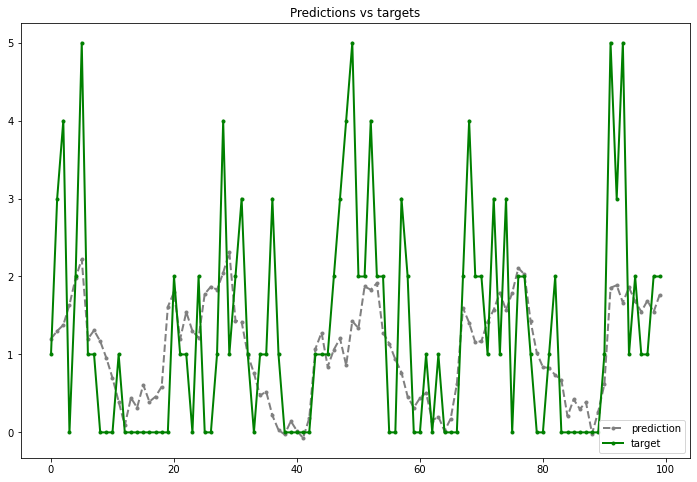

In [67]:
# Plots single cell value
plt.figure(figsize=(12,8))
CELL=(4,2)

# Parameters
offset=0
data_points=100

# Don't touch
lim=offset+data_points
assert lim<len(out)
t=[i for i in range(len(out[offset:lim]))]
plt.plot(t, [x[CELL] for x in out][offset:lim], color='grey', marker='o', linestyle='dashed', linewidth=2, markersize=3, label='prediction')
plt.plot(t, [x[CELL] for x in target][offset:lim], color='green', marker='o', linestyle='solid', linewidth=2, markersize=3, label='target')
plt.legend()
plt.title("Predictions vs targets")
plt.show()

## Calculate Accuracy

In [68]:
def calculate_absolute(inp, lab):
    return np.sum(np.abs(lab-inp))
def calculate_relative(inp, lab, mean_grid):
    return np.sum(np.abs(lab-inp)/(1+mean_grid))

In [69]:
abs_v = np.mean(np.abs(list(map(calculate_absolute,out,target))))
rel_v = np.mean(np.abs(list(map(calculate_relative,out,target,train_data.mean_grid))))
print(abs_v,rel_v)

21.429742086993897 16.046263256948905


## Joint plot for all predictions

In [38]:
# Load in data from models
linear_model=out
with open('baselineLSTM.npy', 'rb') as f:
    baseLSTM = np.load(f)
    
    
with open('normlstmfeatures.npy', 'rb') as f:
    CLSTM_BN_F = np.load(f)
    
    
with open('vanillaConvLSTM.npy', 'rb') as f:
    vanillaConvLSTM = np.load(f)

with open('CLSTM_BN.npy', 'rb') as f:
    CLSTM_BN = np.load(f)

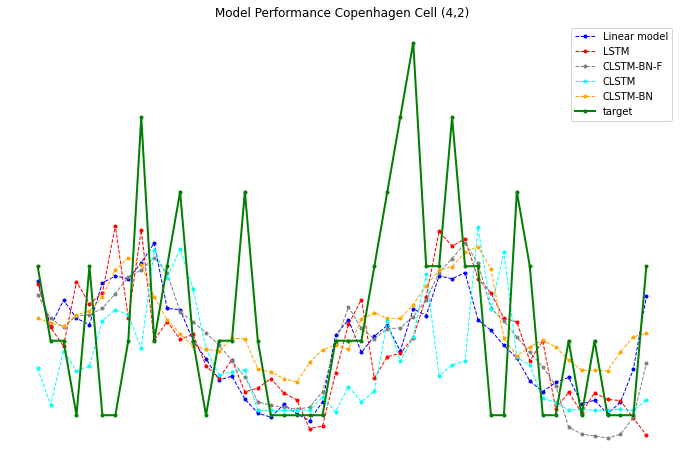

In [45]:
plt.figure(figsize=(12,8))

# Parameters
offset=20
data_points=48

# Don't touch
lim=offset+data_points
assert lim<len(out)
t=[i for i in range(len(out[offset:lim]))]

# Add all the lines for each predictor
plt.plot(t, linear_model[offset:lim], color='blue', marker='o', linestyle='dashed', linewidth=1, markersize=3, label='Linear model')
plt.plot(t, baseLSTM[offset:lim], color='red', marker='o', linestyle='dashed', linewidth=1, markersize=3, label='LSTM')
plt.plot(t, CLSTM_BN_F[offset:lim], color='grey', marker='o', linestyle='dashed', linewidth=1, markersize=3, label='CLSTM-BN-F')
plt.plot(t, vanillaConvLSTM[offset:lim], color='aqua', marker='o', linestyle='dashed', linewidth=1, markersize=3, label='CLSTM')
plt.plot(t, CLSTM_BN[offset:lim], color='orange', marker='o', linestyle='dashed', linewidth=1, markersize=3, label='CLSTM-BN')


plt.plot(t, target[offset:lim], color='green', marker='o', linestyle='solid', linewidth=2, markersize=3, label='target')
plt.legend()
plt.axis('off')
plt.title("Model Performance Copenhagen Cell (4,2)")
plt.savefig('ModelPerformance')